Unparsed / NaN salary_max_old rows: 0
Unparsed / NaN company_size_num rows: 15
NaN company_size_group rows: 15

Sample company size parsing:
       company company_size  company_size_num company_size_group
0  company_003     €352.44B      3.524400e+11              large
1  company_005      155,030      1.550300e+05              large
2  company_007       25,930      2.593000e+04              large
3  company_008       34,690      3.469000e+04              large
4  company_009        1,800      1.800000e+03             medium

Job count per company size group:
  company_size_group  job_count
0              large        549
1             medium        171
2              small        205


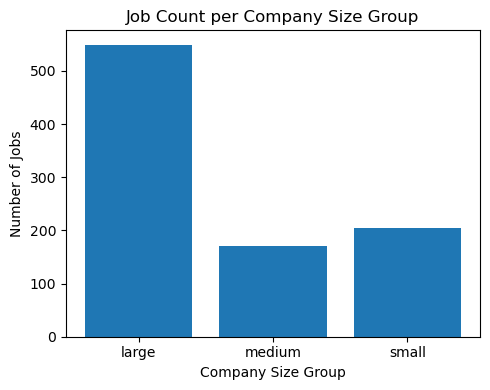


Average NEW salary_max per company size group:
  company_size_group  salary_max_new
0              large   179625.238616
1             medium   166848.463158
2              small   158667.356098


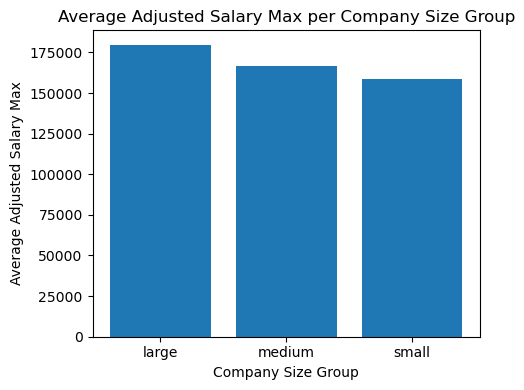


Average skill count per job per company size group:
  company_size_group  skill_count
0              large     5.389800
1             medium     3.766082
2              small     2.434146


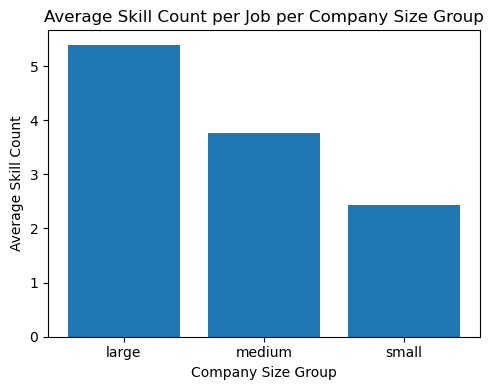

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ast

# ============================================================
# 1. Load dataset
# ============================================================
df = pd.read_csv("../data/data_science_job_posts_2025.csv")
df = df[~df["company"].isin(["company_967", "company_209"])].copy()

# ============================================================
# 2. Compute OLD salary_max from "salary"
#    Example: "€100,472 - €200,938" -> 200938.0
# ============================================================
def extract_salary_max(s):
    if pd.isna(s):
        return np.nan
    nums = re.findall(r"[\d,]+", str(s))
    if not nums:
        return np.nan
    return float(nums[-1].replace(",", ""))

df["salary_max_old"] = df["salary"].apply(extract_salary_max)
n_unparsed_salary = df["salary_max_old"].isna().sum()
print(f"Unparsed / NaN salary_max_old rows: {n_unparsed_salary}")

# ============================================================
# 3. Company size parsers (NUM + GROUP)
#    Rules:
#    - If company_size contains B or M -> group = large
#    - Else treat as employee count:
#         < 1000   -> small
#         < 10000  -> medium
#         >= 10000 -> large
# ============================================================
def parse_company_size_num(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip().replace("€", "").upper()

    # Revenue formats: €352.44B, 45M, etc.
    if "B" in s:
        try:
            return float(s.replace("B", "")) * 1_000_000_000
        except ValueError:
            return np.nan
    if "M" in s:
        try:
            return float(s.replace("M", "")) * 1_000_000
        except ValueError:
            return np.nan

    # Employee counts: "155,030"
    s_clean = s.replace(",", "")
    try:
        return float(s_clean)
    except ValueError:
        return np.nan


def company_size_group(original, numeric):
    if pd.isna(original) or pd.isna(numeric):
        return np.nan

    s = str(original).upper()

    # Rule 1: if contains B or M -> always large
    if "B" in s or "M" in s:
        return "large"

    # Rule 2: employee-based thresholds
    if numeric < 1000:
        return "small"
    elif numeric < 10000:
        return "medium"
    else:
        return "large"


df["company_size_num"] = df["company_size"].apply(parse_company_size_num)

df["company_size_group"] = df.apply(
    lambda row: company_size_group(row["company_size"], row["company_size_num"]),
    axis=1
)

n_unparsed_company = df["company_size_num"].isna().sum()
n_unparsed_group = df["company_size_group"].isna().sum()
df["company_size_group"].dropna()
print(f"Unparsed / NaN company_size_num rows: {n_unparsed_company}")
print(f"NaN company_size_group rows: {n_unparsed_group}")

print("\nSample company size parsing:")
print(df[[
    "company",
    "company_size",
    "company_size_num",
    "company_size_group"
]].head())

# ============================================================
# 4. NEW salary_max based on company_size_group
#    large  -> old + 30%
#    medium -> old + 10%
#    small/NaN/others -> unchanged
# ============================================================
def adjust_salary_max(row):
    old = row["salary_max_old"]
    group = row["company_size_group"]

    if pd.isna(old):
        return np.nan

    if group == "large":
        return old * 1.30
    elif group == "medium":
        return old * 1.10
    else:
        return old

df["salary_max_new"] = df.apply(adjust_salary_max, axis=1)
# Use only rows with valid group for group-based EDA
df_grouped = df.dropna(subset=["company_size_group"]).copy()

# ============================================================
# 5. Job count per company group (bar plot)
# ============================================================
job_counts = (
    df_grouped["company_size_group"]
    .value_counts()
    .sort_index()
    .reset_index()
)
job_counts.columns = ["company_size_group", "job_count"]

print("\nJob count per company size group:")
print(job_counts)

plt.figure(figsize=(5, 4))
plt.bar(job_counts["company_size_group"], job_counts["job_count"])
plt.title("Job Count per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

# ============================================================
# 6. Average NEW salary_max per company group (bar plot)
# ============================================================
salary_stats = (
    df_grouped.groupby("company_size_group")["salary_max_new"]
    .mean()
    .reset_index()
    .sort_values("company_size_group")
)

print("\nAverage NEW salary_max per company size group:")
print(salary_stats)

plt.figure(figsize=(5, 4))
plt.bar(salary_stats["company_size_group"], salary_stats["salary_max_new"])
plt.title("Average Adjusted Salary Max per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Adjusted Salary Max")
plt.tight_layout()
plt.show()

# ============================================================
# 7. Average skill count per job per group (data + bar plot)
#    skills column example: "['spark', 'r', 'python', ...]"
# ============================================================
def count_skills(s):
    if pd.isna(s):
        return 0
    text = str(s)
    # Try to parse as Python list
    try:
        parsed = ast.literal_eval(text)
        if isinstance(parsed, (list, tuple)):
            return len(parsed)
    except (SyntaxError, ValueError):
        pass
    # Fallback: treat as comma-separated inside brackets
    text = text.strip("[]")
    if not text:
        return 0
    return len([x for x in text.split(",") if x.strip()])

df_grouped["skill_count"] = df_grouped["skills"].apply(count_skills)

skill_stats = (
    df_grouped.groupby("company_size_group")["skill_count"]
    .mean()
    .reset_index()
    .sort_values("company_size_group")
)

print("\nAverage skill count per job per company size group:")
print(skill_stats)

plt.figure(figsize=(5, 4))
plt.bar(skill_stats["company_size_group"], skill_stats["skill_count"])
plt.title("Average Skill Count per Job per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Skill Count")
plt.tight_layout()
plt.show()

df.to_csv("../data/data_science_job_posts_2025_clean2.csv", index=False)


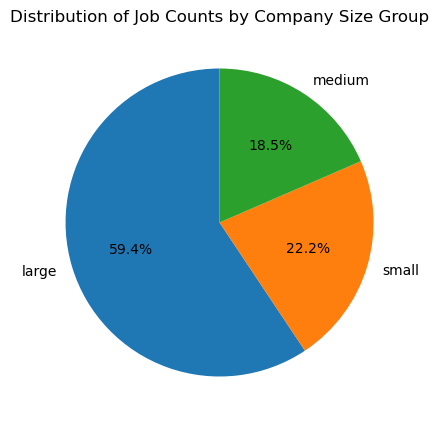

In [108]:
df_grouped["company_size_group"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(5, 5), startangle=90
)
plt.ylabel("")
plt.title("Distribution of Job Counts by Company Size Group")
plt.show()


<Figure size 600x400 with 0 Axes>

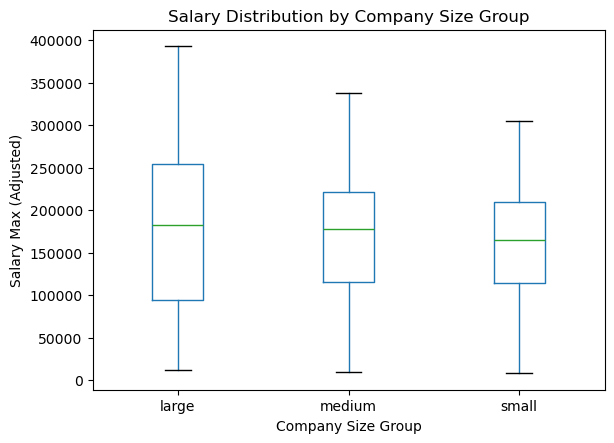

In [109]:
plt.figure(figsize=(6, 4))
df_grouped.boxplot(column="salary_max_new", by="company_size_group", grid=False)
plt.title("Salary Distribution by Company Size Group")
plt.suptitle("")
plt.xlabel("Company Size Group")
plt.ylabel("Salary Max (Adjusted)")
plt.show()


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_52852/65310525.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


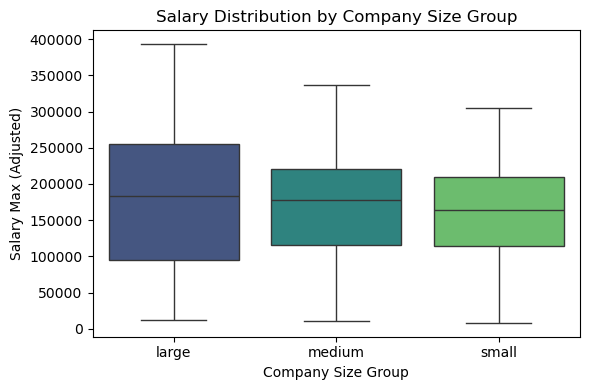

In [110]:
plt.figure(figsize=(6, 4))

# Use seaborn for easy coloring
import seaborn as sns
sns.boxplot(
    data=df_grouped,
    x="company_size_group",
    y="salary_max_new",
    palette="viridis"   # great for presentations
)

plt.title("Salary Distribution by Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Salary Max (Adjusted)")
plt.tight_layout()
plt.show()


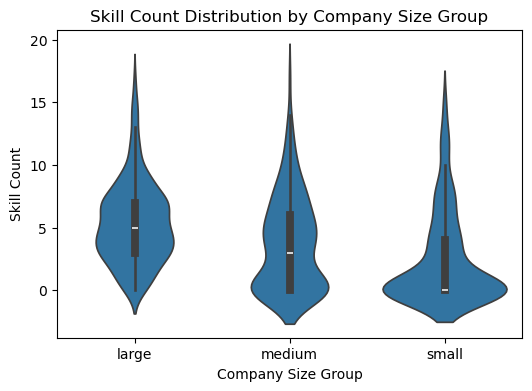

In [111]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.violinplot(data=df_grouped, x="company_size_group", y="skill_count")
plt.title("Skill Count Distribution by Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Skill Count")
plt.show()


/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_52852/227915381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


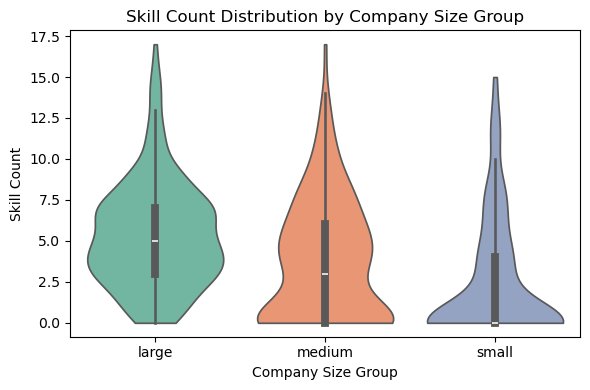

In [112]:
plt.figure(figsize=(6, 4))

sns.violinplot(
    data=df_grouped,
    x="company_size_group",
    y="skill_count",
    palette="Set2",    # soft pastel shades
    cut=0
)

plt.title("Skill Count Distribution by Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Skill Count")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
import ast

# ============================================================
# 1. Load dataset + drop unwanted companies
# ============================================================
df = pd.read_csv("../data/data_science_job_posts_2025.csv")
df = df[~df["company"].isin(["company_967", "company_209"])].copy()

# ============================================================
# 2. salary_max (ONLY salary column kept in final output)
#    Example: "€100,472 - €200,938" -> 200938.0
# ============================================================
def extract_salary_max(s):
    if pd.isna(s):
        return np.nan
    nums = re.findall(r"[\d,]+", str(s))
    if not nums:
        return np.nan
    return float(nums[-1].replace(",", ""))

df["salary_max"] = df["salary"].apply(extract_salary_max)

# Drop all other salary-related columns (keep only salary_max)
salary_cols_to_drop = [c for c in df.columns if c.startswith("salary") and c != "salary_max"]
df = df.drop(columns=salary_cols_to_drop, errors="ignore")

# ============================================================
# 3. Company size numeric + group
# ============================================================
def parse_company_size_num(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip().replace("€", "").upper()

    # Revenue formats: "352.44B", "45M", etc.
    if "B" in s:
        try:
            return float(s.replace("B", "")) * 1_000_000_000
        except ValueError:
            return np.nan
    if "M" in s:
        try:
            return float(s.replace("M", "")) * 1_000_000
        except ValueError:
            return np.nan

    # Employee counts: "155,030"
    s_clean = s.replace(",", "")
    try:
        return float(s_clean)
    except ValueError:
        return np.nan


def company_size_group(original, numeric):
    if pd.isna(original) or pd.isna(numeric):
        return np.nan

    s = str(original).upper()

    # If contains B or M -> always large
    if "B" in s or "M" in s:
        return "large"

    # Employee-based thresholds
    if numeric < 1000:
        return "small"
    elif numeric < 10000:
        return "medium"
    else:
        return "large"


df["company_size_num"] = df["company_size"].apply(parse_company_size_num)
df["company_size_group"] = df.apply(
    lambda row: company_size_group(row["company_size"], row["company_size_num"]),
    axis=1,
)

# ============================================================
# 4. Clean skills column -> skills_clean (pipe-separated)
#    Example:
#      "['spark', 'r', 'python']" -> "spark|r|python"
# ============================================================
def clean_skills(s):
    if pd.isna(s):
        return ""

    text = str(s)

    # Try to parse as Python list
    skills_raw = None
    try:
        parsed = ast.literal_eval(text)
        if isinstance(parsed, (list, tuple, set)):
            skills_raw = list(parsed)
    except (SyntaxError, ValueError, TypeError):
        pass

    # Fallback: split on comma or |
    if skills_raw is None:
        skills_raw = re.split(r"[,\|]", text)

    cleaned = []
    for sk in skills_raw:
        sk_str = str(sk).strip().strip("'\"").lower()
        if sk_str:
            cleaned.append(sk_str)

    # Deduplicate while preserving order
    seen = set()
    unique = []
    for sk in cleaned:
        if sk not in seen:
            seen.add(sk)
            unique.append(sk)

    return "|".join(unique)


df["skills_clean"] = df["skills"].apply(clean_skills)

# Optional: skill count per job (can be useful later)
df["skill_count"] = df["skills_clean"].apply(lambda s: 0 if s == "" else s.count("|") + 1)

# ============================================================
# 5. Save cleaned file
# ============================================================
df.to_csv("../data/data_science_job_posts_2025_clean2.csv", index=False)


In [114]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix

# ============================================================
# 1. Load dataset
# ============================================================
df = pd.read_csv("../data/data_science_job_posts_2025_clean2.csv")

# Keep only required columns
df = df[[
    "skills_clean",
    "skill_count",
    "company_size_group",
    "salary_max",
    "seniority_level",
    "job_title"
]].copy()

# ------------------------------------------------------------
# 1.1 Handle missing values
# ------------------------------------------------------------
# Text columns: replace NaN with empty string
df["skills_clean"] = df["skills_clean"].fillna("")
df["job_title"] = df["job_title"].fillna("")

# Categorical columns: replace NaN with "unknown"
df["company_size_group"] = df["company_size_group"].fillna("unknown")
df["seniority_level"] = df["seniority_level"].fillna("unknown")

# Numeric columns: drop rows where salary_max or skill_count is missing
df = df.dropna(subset=["salary_max", "skill_count"]).copy()

print("Dataset shape after cleaning:", df.shape)

# ============================================================
# 2. TF-IDF for skills_clean
#    skills_clean format: "spark|r|python|..."
# ============================================================
tfidf_skills = TfidfVectorizer(token_pattern=r"[^|]+")
X_skills = tfidf_skills.fit_transform(df["skills_clean"])
print("TF-IDF skills matrix:", X_skills.shape)

# ============================================================
# 3. TF-IDF for job_title
# ============================================================
tfidf_titles = TfidfVectorizer(stop_words="english")
X_titles = tfidf_titles.fit_transform(df["job_title"])
print("TF-IDF job title matrix:", X_titles.shape)

# ============================================================
# 4. One-Hot Encoding for:
#    - company_size_group
#    - seniority_level
# ============================================================
ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore")

X_ohe = ohe.fit_transform(df[["company_size_group", "seniority_level"]])
print("One-hot matrix:", X_ohe.shape)

# ============================================================
# 5. Numeric features: salary_max, skill_count (scaled)
# ============================================================
scaler = StandardScaler()
X_numeric_array = scaler.fit_transform(df[["salary_max", "skill_count"]])
X_numeric = csr_matrix(X_numeric_array)
print("Numeric matrix:", X_numeric.shape)

# ============================================================
# 6. HYBRID EMBEDDING = CONCATENATE ALL
# ============================================================
X_hybrid = hstack([
    X_skills,      # TF-IDF skills
    X_titles,      # TF-IDF job titles
    X_ohe,         # one-hot company_size_group + seniority_level
    X_numeric      # salary_max + skill_count (scaled)
]).tocsr()

print("\nFINAL HYBRID VECTOR SHAPE:", X_hybrid.shape)

# df is your job metadata (rows aligned with X_hybrid)
# X_hybrid is ready for cosine similarity / KNN recommender


Dataset shape after cleaning: (940, 6)
TF-IDF skills matrix: (940, 33)
TF-IDF job title matrix: (940, 6)
One-hot matrix: (940, 9)
Numeric matrix: (940, 2)

FINAL HYBRID VECTOR SHAPE: (940, 50)



Job count per company_size_group:
company_size_group
large      549
medium     171
small      205
unknown     15
Name: count, dtype: int64


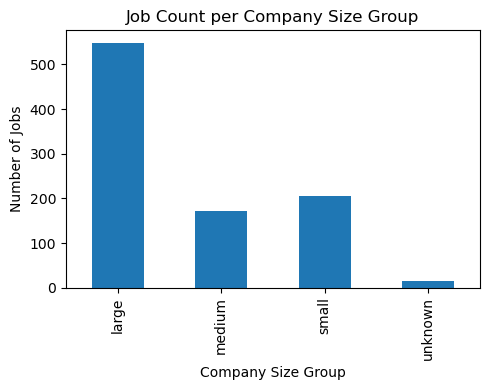


Average salary_max per company_size_group:
  company_size_group     salary_max
0              large  138173.260474
1             medium  151680.421053
2              small  158667.356098
3            unknown   46050.000000


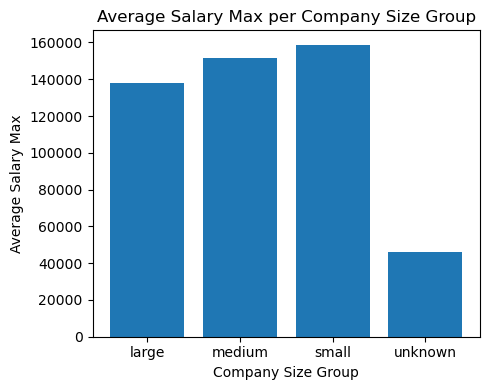


Average skill_count per company_size_group:
  company_size_group  skill_count
0              large     5.389800
1             medium     3.766082
2              small     2.434146
3            unknown     3.666667


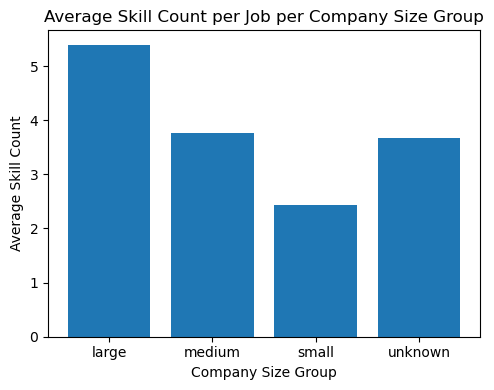

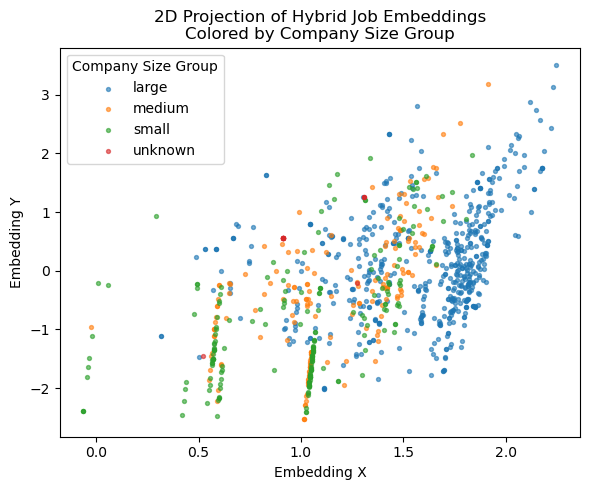

In [115]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# ============================================================
# 7. Job count per company_size_group
# ============================================================
group_counts = (
    df["company_size_group"]
    .value_counts()
    .sort_index()
)

print("\nJob count per company_size_group:")
print(group_counts)

plt.figure(figsize=(5, 4))
group_counts.plot(kind="bar")
plt.title("Job Count per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

# ============================================================
# 8. Average salary_max per company_size_group
# ============================================================
group_salary = (
    df.groupby("company_size_group")["salary_max"]
      .mean()
      .reset_index()
      .sort_values("company_size_group")
)

print("\nAverage salary_max per company_size_group:")
print(group_salary)

plt.figure(figsize=(5, 4))
plt.bar(group_salary["company_size_group"], group_salary["salary_max"])
plt.title("Average Salary Max per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Salary Max")
plt.tight_layout()
plt.show()

# ============================================================
# 9. Average skill_count per company_size_group
# ============================================================
group_skills = (
    df.groupby("company_size_group")["skill_count"]
      .mean()
      .reset_index()
      .sort_values("company_size_group")
)

print("\nAverage skill_count per company_size_group:")
print(group_skills)

plt.figure(figsize=(5, 4))
plt.bar(group_skills["company_size_group"], group_skills["skill_count"])
plt.title("Average Skill Count per Job per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Skill Count")
plt.tight_layout()
plt.show()

# ============================================================
# 10. 2D Projection of Hybrid Embeddings (TruncatedSVD)
# ============================================================
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_hybrid)

# Attach coordinates to df for plotting
df["emb_x"] = X_2d[:, 0]
df["emb_y"] = X_2d[:, 1]

plt.figure(figsize=(6, 5))

for group in df["company_size_group"].unique():
    subset = df[df["company_size_group"] == group]
    plt.scatter(
        subset["emb_x"],
        subset["emb_y"],
        s=8,
        alpha=0.6,
        label=str(group),
    )

plt.title("2D Projection of Hybrid Job Embeddings\nColored by Company Size Group")
plt.xlabel("Embedding X")
plt.ylabel("Embedding Y")
plt.legend(title="Company Size Group")
plt.tight_layout()
plt.show()


In [116]:
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# 7. Helper: recommend similar jobs given a job index
# ============================================================
def recommend_similar_jobs(job_index, top_k=10):
    """
    Recommend top_k jobs similar to the job at job_index,
    based on cosine similarity over X_hybrid.
    """
    if job_index < 0 or job_index >= X_hybrid.shape[0]:
        raise IndexError("job_index out of range")

    # 1 x D sparse row
    query_vec = X_hybrid[job_index]

    # Compute cosine similarity with all jobs
    sims = cosine_similarity(query_vec, X_hybrid).flatten()

    # Sort by similarity (descending), skip the job itself
    ranked_idx = np.argsort(-sims)
    ranked_idx = ranked_idx[ranked_idx != job_index]

    top_idx = ranked_idx[:top_k]
    top_sims = sims[top_idx]

    # Build a nice result DataFrame
    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    # Reorder columns for readability
    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
    ]
    # Some columns (like company) may not exist in this df subset, handle that:
    available_cols = [c for c in cols if c in results.columns]
    return results[available_cols]

# Example: try recommendations for job at index 0
print("\n=== Recommendations for job index 0 ===")
print(df.iloc[0][["job_title", "company_size_group", "salary_max", "skills_clean"]])
print("\nTop-10 similar jobs:")
print(recommend_similar_jobs(0, top_k=10).to_string(index=False))



=== Recommendations for job index 0 ===
job_title                                               data scientist
company_size_group                                               large
salary_max                                                    200938.0
skills_clean          spark|r|python|scala|machine learning|tensorflow
Name: 0, dtype: object

Top-10 similar jobs:
     job_title company_size_group  salary_max seniority_level                                             skills_clean  similarity
data scientist              large    200934.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.984334
data scientist              large    197284.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.983785
data scientist              large    183991.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.978126
data scientist              large    164400.0          senior         spark|r|python|scala|machine learnin

In [117]:
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# Convert free-text query → hybrid embedding → top-k jobs
# ============================================================

def embed_query_text(query_text):
    """
    Convert text query into the same hybrid feature space as job embeddings.
    Uses:
        - TF-IDF (skills)
        - TF-IDF (job title)
        - One-hot company group (unknown)
        - One-hot seniority (from text, guessed)
        - Numeric salary (0) and skill_count (0)
    """
    # --- 1. Convert raw text into pseudo-fields ---
    q = str(query_text).lower()

    # Heuristic: extract possible skills (match TF-IDF vocab)
    skill_tokens = []
    for skill in tfidf_skills.get_feature_names_out():
        if skill in q:
            skill_tokens.append(skill)
    skills_clean_q = "|".join(skill_tokens)

    # Guess seniority from text
    if "senior" in q:
        seniority = "senior"
    elif "lead" in q:
        seniority = "senior"
    elif "staff" in q:
        seniority = "senior"
    elif "intern" in q:
        seniority = "intern"
    elif "junior" in q:
        seniority = "junior"
    else:
        seniority = "unknown"

    # Company size unknown for user query
    company_group = "unknown"

    # Numeric placeholders → scaled to ~0 by StandardScaler
    salary_val = 0
    skill_count_val = len(skill_tokens)

    # --- 2. Build the hybrid embedding ---
    q_skills = tfidf_skills.transform([skills_clean_q])
    q_title  = tfidf_titles.transform([query_text])

    q_ohe = ohe.transform([[company_group, seniority]])

    q_num = scaler.transform([[salary_val, skill_count_val]])
    q_num = csr_matrix(q_num)

    # Final hybrid vector
    q_vec = hstack([q_skills, q_title, q_ohe, q_num]).tocsr()
    return q_vec


def search_jobs(query_text, top_k=10):
    """
    Main function:
      free text → vector → cosine similarity → top-k jobs
    """
    q_vec = embed_query_text(query_text)
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    top_idx = np.argsort(-sims)[:top_k]
    top_sims = sims[top_idx]

    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity"
    ]
    return results[[c for c in cols if c in results.columns]]


# ============================
# 🔥 Try an example query
# ============================
query = "Senior machine learning engineer with python skills"
print("\nUser Query:", query)
print("\nTop Recommendations:")
print(search_jobs(query, top_k=10).to_string(index=False))



User Query: Senior machine learning engineer with python skills

Top Recommendations:
                job_title company_size_group  salary_max seniority_level                             skills_clean  similarity
machine learning engineer              large     26186.0          senior            azure|machine learning|python    0.772673
machine learning engineer              large     26185.0          senior                               sql|python    0.754911
machine learning engineer              large     26186.0          senior                               sql|python    0.754910
machine learning engineer              large      9584.0          senior deep learning|aws|machine learning|azure    0.746884
machine learning engineer              large     63941.0          senior           java|machine learning|r|python    0.740879
machine learning engineer              small     36342.0          senior                                             0.727699
machine learning engineer      

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== Example recommendations for job index 0 ===
job_title                                               data scientist
company_size_group                                               large
salary_max                                                    200938.0
skills_clean          spark|r|python|scala|machine learning|tensorflow
Name: 0, dtype: object
     job_title company_size_group  salary_max  similarity
data scientist              large    200934.0    0.984334
data scientist              large    197284.0    0.983785
data scientist              large    183991.0    0.978126
data scientist              large    164400.0    0.975788
data scientist              large    213719.0    0.971842
data scientist              large    215273.0    0.971443
data scientist              large    165590.0    0.959947
data scientist              large    261214.0    0.948461
data scientist              large    263104.0    0.946425
data scientist              large    263106.0    0.946423
data s

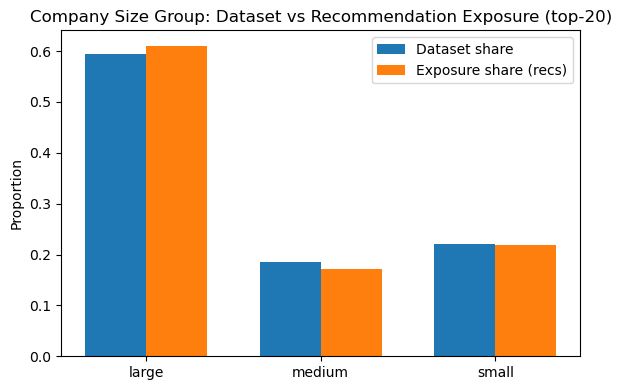

In [118]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ============================================================
# 11. Baseline recommender: similar jobs by index
# ============================================================
def recommend_similar_jobs(job_index, top_k=20):
    """
    Recommend top_k jobs similar to the job at job_index,
    based on cosine similarity over X_hybrid.
    """
    if job_index < 0 or job_index >= X_hybrid.shape[0]:
        raise IndexError("job_index out of range")

    query_vec = X_hybrid[job_index]
    sims = cosine_similarity(query_vec, X_hybrid).flatten()

    # Sort by similarity (descending), skip the job itself
    ranked_idx = np.argsort(-sims)
    ranked_idx = ranked_idx[ranked_idx != job_index]

    top_idx = ranked_idx[:top_k]
    top_sims = sims[top_idx]

    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    return results


# Quick test
print("\n=== Example recommendations for job index 0 ===")
print(df.iloc[0][["job_title", "company_size_group", "salary_max", "skills_clean"]])
print(
    recommend_similar_jobs(0, top_k=20)[
        ["job_title", "company_size_group", "salary_max", "similarity"]
    ].to_string(index=False)
)


# ============================================================
# 12. Exposure bias measurement (k=20) excluding UNKNOWN group
# ============================================================
def measure_exposure_bias(num_seeds=300, top_k=20, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(df)

    # Filter dataset to exclude unknowns for fair comparison
    valid_df = df[df["company_size_group"] != "unknown"].copy()

    # Compute dataset-level group proportions (small/medium/large only)
    dataset_counts = valid_df["company_size_group"].value_counts().sort_index()
    dataset_share = dataset_counts / dataset_counts.sum()

    seed_indices = rng.integers(0, n, size=num_seeds)

    exposure_counts = {}

    for idx in seed_indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)

        # Drop unknown company group from the recommended list
        recs_valid = recs[recs["company_size_group"] != "unknown"]

        counts = recs_valid["company_size_group"].value_counts()
        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    # Convert to Series
    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    # Build summary table
    groups = sorted(dataset_share.index)

    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print(f"\n=== Exposure Bias Summary (num_seeds={num_seeds}, top_k={top_k}) ===")
    print(summary.to_string(index=False))

    # Plot dataset vs exposure
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title("Company Size Group: Dataset vs Recommendation Exposure (top-20)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary


# ============================================================
# 13. Run bias measurement
# ============================================================
bias_summary = measure_exposure_bias(num_seeds=300, top_k=20)



=== Index-Based Exposure Bias Summary ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622        0.178886        0.807167
            medium       0.184865        0.118768        0.642460
             large       0.593514        0.702346        1.183370


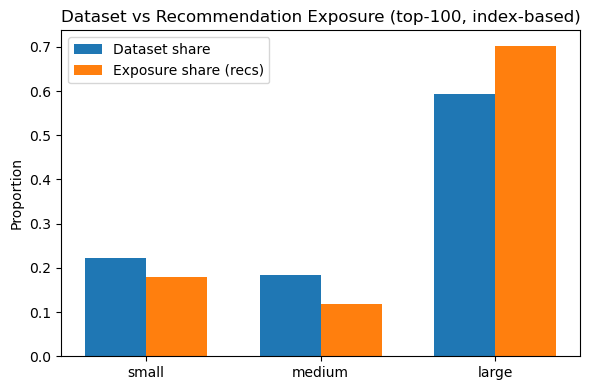

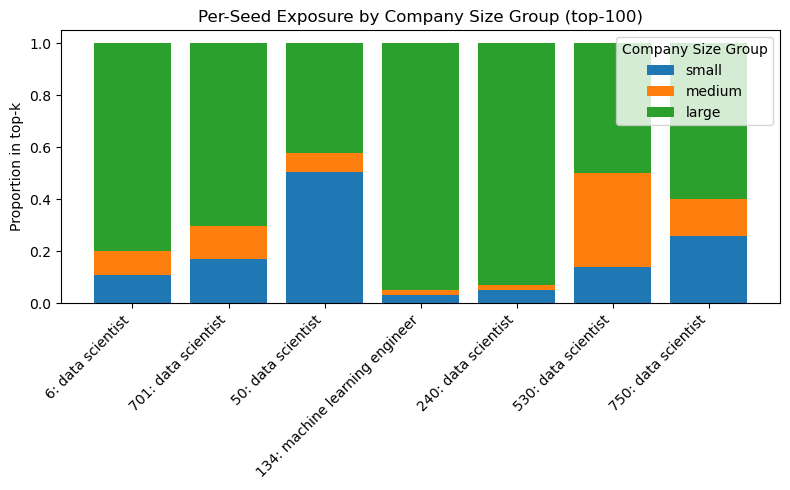

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Bias measurement based on JOB INDICES using recommend_similar_jobs()
# ============================================================

def measure_exposure_bias_job_indices(indices, top_k=20):
    """
    Measure exposure bias using index-based job recommendations.

    For each index in `indices`:
      - call recommend_similar_jobs(idx, top_k)
      - count how many small/medium/large company jobs appear
    Then:
      - compare exposure distribution to dataset distribution
      - return summary DataFrame + per-seed breakdown
    """

    # ---- 1. Dataset-level distribution (exclude 'unknown') ----
    df_valid = df[df["company_size_group"] != "unknown"].copy()

    dataset_counts = (
        df_valid["company_size_group"]
        .value_counts()
        .sort_index()
    )
    dataset_share = dataset_counts / dataset_counts.sum()

    # ---- 2. Aggregate exposure across all seeds ----
    exposure_counts = {}
    per_seed_exposure = []  # for per-seed plot

    for idx in indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)

        # Ensure we drop unknowns (if any)
        recs_valid = recs[recs["company_size_group"] != "unknown"].copy()

        counts = recs_valid["company_size_group"].value_counts()
        exposure_counts_for_seed = {
            "seed_index": idx,
            "seed_title": str(df.iloc[idx]["job_title"]) if "job_title" in df.columns else f"job_{idx}",
            "small": counts.get("small", 0),
            "medium": counts.get("medium", 0),
            "large": counts.get("large", 0),
        }
        per_seed_exposure.append(exposure_counts_for_seed)

        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    # Convert overall exposure to shares
    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    # ---- 3. Build summary table (overall) ----
    groups = ["small", "medium", "large"]
    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print("\n=== Index-Based Exposure Bias Summary ===")
    print(summary.to_string(index=False))

    # ---- 4. Overall bar plot: dataset vs exposure ----
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title(f"Dataset vs Recommendation Exposure (top-{top_k}, index-based)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 5. Per-seed stacked bar plot ----
    per_seed_df = pd.DataFrame(per_seed_exposure)

    # Normalize per seed to proportions
    per_seed_df["total"] = per_seed_df[["small", "medium", "large"]].sum(axis=1)
    for g in groups:
        per_seed_df[g + "_share"] = np.where(
            per_seed_df["total"] > 0,
            per_seed_df[g] / per_seed_df["total"],
            0.0,
        )

    # Shorten seed labels for plotting: "idx: title..."
    per_seed_df["seed_label"] = (
        per_seed_df["seed_index"].astype(str)
        + ": "
        + per_seed_df["seed_title"].str.slice(0, 25)
        + np.where(per_seed_df["seed_title"].str.len() > 25, "...", "")
    )

    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(per_seed_df))
    colors = {"small": "tab:blue", "medium": "tab:orange", "large": "tab:green"}

    for g in groups:
        plt.bar(
            per_seed_df["seed_label"],
            per_seed_df[g + "_share"],
            bottom=bottom,
            label=g,
            color=colors[g],
        )
        bottom += per_seed_df[g + "_share"].values

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion in top-k")
    plt.title(f"Per-Seed Exposure by Company Size Group (top-{top_k})")
    plt.legend(title="Company Size Group")
    plt.tight_layout()
    plt.show()

    return summary, per_seed_df


# ============================================================
# Example: run bias measurement on a set of seed indices
# ============================================================

seed_indices = [
    6,
    701,
    50,
    134,
    240,
    530,
    750
]

bias_summary_index, per_seed_detail = measure_exposure_bias_job_indices(
    indices=seed_indices,
    top_k=100,
)


In [119]:
from sklearn.metrics.pairwise import cosine_similarity

# ============================================================
# Helper: embed free-text query into the HYBRID space
# ============================================================
def embed_query_text(query_text):
    """
    Convert a free-text query like:
      "Senior machine learning engineer with Python skills"
    into the same hybrid feature space as X_hybrid.
    Uses:
      - TF-IDF on skills (matched by vocab)
      - TF-IDF on job_title (full text)
      - One-hot for (company_size_group="unknown", guessed seniority)
      - Scaled numerics: salary_max ~ 0, skill_count from matched skills
    """

    q = str(query_text).lower()

    # --- 1. Extract possible skill tokens based on TF-IDF vocab ---
    skill_tokens = []
    for skill in tfidf_skills.get_feature_names_out():
        if skill.lower() in q:
            skill_tokens.append(skill)
    skills_clean_q = "|".join(skill_tokens)

    # --- 2. Guess seniority from text ---
    if "senior" in q or "lead" in q or "staff" in q or "principal" in q:
        seniority = "senior"
    elif "intern" in q:
        seniority = "intern"
    elif "junior" in q or "entry" in q:
        seniority = "junior"
    else:
        seniority = "unknown"

    # --- 3. Company size group: unknown for user queries ---
    company_group = "unknown"

    # --- 4. Numeric placeholders ---
    # salary_max: 0 means "no explicit preference" → scaler will center it
    salary_val = 0.0
    skill_count_val = len(skill_tokens)

    # --- 5. Build each feature block using existing transformers ---
    # TF-IDF skills
    q_skills = tfidf_skills.transform([skills_clean_q])

    # TF-IDF job title (full text)
    q_title = tfidf_titles.transform([query_text])

    # One-hot for company_size_group + seniority_level
    q_ohe = ohe.transform([[company_group, seniority]])

    # Numeric features: salary_max, skill_count
    q_num_arr = scaler.transform([[salary_val, skill_count_val]])
    q_num = csr_matrix(q_num_arr)

    # --- 6. Final hybrid vector ---
    q_vec = hstack([q_skills, q_title, q_ohe, q_num]).tocsr()
    return q_vec


# ============================================================
# Base recommender: text → top-k jobs
# ============================================================
def search_jobs(query_text, top_k=20):
    """
    Base recommender:
      - embeds free-text query
      - computes similarity
      - returns top_k jobs
      - removes company_size_group == 'unknown'
    """
    q_vec = embed_query_text(query_text)
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    # Sort by similarity
    top_idx = np.argsort(-sims)

    # Build results DataFrame before filtering
    results = df.iloc[top_idx].copy()
    results["similarity"] = sims[top_idx]

    # -------------------------------
    # REMOVE UNKNOWN COMPANY GROUPS
    # -------------------------------
    results = results[results["company_size_group"] != "unknown"]

    # Now take top_k after filtering
    results = results.head(top_k)

    # Columns in nice order
    cols = [
        "job_title",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
    ]
    cols = [c for c in cols if c in results.columns]

    return results[cols]


# ============================================================
# Quick test of the text-based BASE recommender
# ============================================================
query = "machine learning engineer with Python skills"
print("\nUser query:", query)
print("\nTop-20 recommended jobs:")
print(search_jobs(query, top_k=20).to_string(index=False))



User query: machine learning engineer with Python skills

Top-20 recommended jobs:
                job_title company_size_group  salary_max seniority_level                             skills_clean  similarity
machine learning engineer              small     36340.0         unknown                                             0.727702
machine learning engineer              large     26185.0          junior                         machine learning    0.641775
machine learning engineer              large     26188.0          junior                         machine learning    0.641771
machine learning engineer              large     26376.0        midlevel                         machine learning    0.641484
machine learning engineer              large     26378.0        midlevel                         machine learning    0.641481
machine learning engineer              large     26379.0        midlevel                         machine learning    0.641479
machine learning engineer         

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== Text-Query Based Exposure Bias Summary ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.28125        1.269055
            medium       0.184865         0.11250        0.608553
             large       0.593514         0.60625        1.021459


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

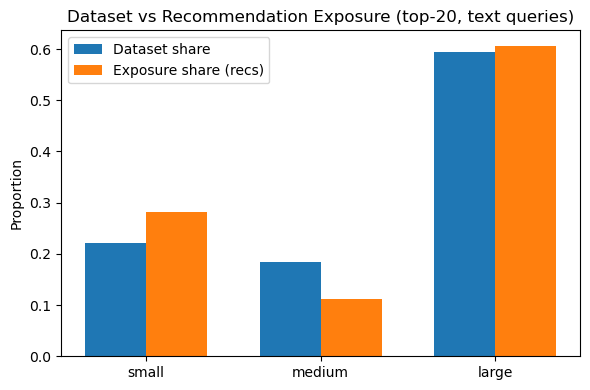

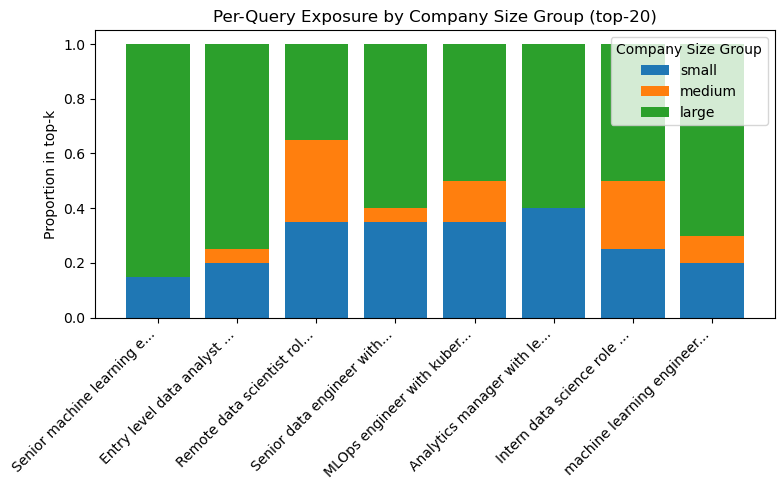

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Bias measurement based on TEXT QUERIES using search_jobs()
# ============================================================

def measure_exposure_bias_text_queries(queries, top_k=20):
    """
    Measure exposure bias using text-based recommendations.

    For each query in `queries`:
      - call search_jobs(query, top_k)
      - count how many small/medium/large company jobs appear
    Then:
      - compare exposure distribution to dataset distribution
      - return summary DataFrame
    """

    # ---- 1. Dataset-level distribution (exclude 'unknown') ----
    df_valid = df[df["company_size_group"] != "unknown"].copy()

    dataset_counts = (
        df_valid["company_size_group"]
        .value_counts()
        .sort_index()
    )
    dataset_share = dataset_counts / dataset_counts.sum()

    # ---- 2. Aggregate exposure across all queries ----
    exposure_counts = {}
    per_query_exposure = []  # for per-query plot

    for q in queries:
        recs = search_jobs(q, top_k=top_k)

        # search_jobs already drops 'unknown', but we guard anyway
        recs_valid = recs[recs["company_size_group"] != "unknown"].copy()

        counts = recs_valid["company_size_group"].value_counts()
        exposure_counts_for_q = {
            "query": q,
            "small": counts.get("small", 0),
            "medium": counts.get("medium", 0),
            "large": counts.get("large", 0),
        }
        per_query_exposure.append(exposure_counts_for_q)

        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    # Convert overall exposure to shares
    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    # ---- 3. Build summary table (overall) ----
    groups = ["small", "medium", "large"]
    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print("\n=== Text-Query Based Exposure Bias Summary ===")
    print(summary.to_string(index=False))

    # ---- 4. Overall bar plot: dataset vs exposure ----
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title(f"Dataset vs Recommendation Exposure (top-{top_k}, text queries)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 5. Per-query stacked bar plot ----
    per_query_df = pd.DataFrame(per_query_exposure)

    # Normalize per query to proportions
    per_query_df["total"] = per_query_df[["small", "medium", "large"]].sum(axis=1)
    for g in groups:
        per_query_df[g + "_share"] = np.where(
            per_query_df["total"] > 0,
            per_query_df[g] / per_query_df["total"],
            0.0,
        )

    # Shorten query labels for plotting
    per_query_df["query_label"] = per_query_df["query"].str.slice(0, 25) + np.where(
        per_query_df["query"].str.len() > 25, "...", ""
    )

    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(per_query_df))
    colors = {"small": "tab:blue", "medium": "tab:orange", "large": "tab:green"}

    for g in groups:
        plt.bar(
            per_query_df["query_label"],
            per_query_df[g + "_share"],
            bottom=bottom,
            label=g,
            color=colors[g],
        )
        bottom += per_query_df[g + "_share"].values

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion in top-k")
    plt.title(f"Per-Query Exposure by Company Size Group (top-{top_k})")
    plt.legend(title="Company Size Group")
    plt.tight_layout()
    plt.show()

    return summary, per_query_df


# ============================================================
# Example: run bias measurement on text queries
# ============================================================

text_queries = [
    "Senior machine learning engineer with python",
    "Entry level data analyst with SQL and Excel",
    "Remote data scientist role with python",
    "Senior data engineer with spark and aws",
    
    # "Business intelligence analyst with tableau",
    # "NLP research scientist with transformers",
    "MLOps engineer with kubernetes and docker",
    # "Computer vision engineer with pytorch",
    "Analytics manager with leadership experience",
    "Intern data science role with basic python",
    "machine learning engineer with SQL",
]

bias_summary_text, per_query_detail = measure_exposure_bias_text_queries(
    queries=text_queries,
    top_k=20,
)


In [171]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ============================================================
# 1. Group weights for score re-weighting
#    (tune these if you want stronger/weaker fairness)
# ============================================================
GROUP_WEIGHTS = {
    "small": 0.9,   # boost small companies
    "medium": 1.0,  # slight boost
    "large": 0.8,   # baseline
    # "unknown": 1.00  # we anyway filter unknown out
}


# ============================================================
# 2. FAIR recommender: text -> jobs with reweighted scores
# ============================================================
def search_jobs_fair(query_text, top_k=20):
    """
    Fairness-aware recommender:
      - embeds query into hybrid space
      - computes cosine similarity
      - reweights scores by company_size_group
      - drops unknown company sizes
      - returns top_k by fair_score
    """
    # 1) Embed query
    q_vec = embed_query_text(query_text)
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    # 2) Sort by baseline similarity
    ranked_idx = np.argsort(-sims)
    results = df.iloc[ranked_idx].copy()
    results["similarity"] = sims[ranked_idx]

    # 3) Drop unknown company size
    results = results[results["company_size_group"] != "unknown"].copy()

    # 4) Apply group weights
    def get_weight(group):
        return GROUP_WEIGHTS.get(group, 1.0)

    results["fair_weight"] = results["company_size_group"].apply(get_weight)
    results["fair_score"] = results["similarity"] * results["fair_weight"]

    # 5) Re-rank by fair_score
    results = results.sort_values("fair_score", ascending=False).head(top_k)

    # 6) Order columns nicely
    cols = [
        "job_title",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
        "fair_weight",
        "fair_score",
    ]
    cols = [c for c in cols if c in results.columns]
    return results[cols]


# Quick sanity check
example_query = "Senior machine learning engineer with python"
print("\n=== Baseline top-5 ===")
print(search_jobs(example_query, top_k=5).to_string(index=False))

print("\n=== Fair top-5 (reweighted) ===")
print(search_jobs_fair(example_query, top_k=5).to_string(index=False))



=== Baseline top-5 ===
                job_title company_size_group  salary_max seniority_level                             skills_clean  similarity
machine learning engineer              large     26186.0          senior            azure|machine learning|python    0.772673
machine learning engineer              large     26185.0          senior                               sql|python    0.754911
machine learning engineer              large     26186.0          senior                               sql|python    0.754910
machine learning engineer              large      9584.0          senior deep learning|aws|machine learning|azure    0.746884
machine learning engineer              large     63941.0          senior           java|machine learning|r|python    0.740879

=== Fair top-5 (reweighted) ===
                job_title company_size_group  salary_max seniority_level                         skills_clean  similarity  fair_weight  fair_score
machine learning engineer              s

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [172]:
import numpy as np
import pandas as pd

# ============================================================
# 3. Generic exposure bias measurement for text-based recommenders
# ============================================================
def measure_exposure_bias_text_queries(
    recommender_fn,
    queries,
    top_k=20,
    name="model"
):
    """
    Measures exposure of company_size_group in top-k recommendations
    produced by `recommender_fn(query, top_k)`.

    Returns:
      - summary DataFrame with dataset vs exposure
      - average similarity (utility proxy)
    """

    # ---- Dataset distribution (exclude unknown) ----
    df_valid = df[df["company_size_group"] != "unknown"].copy()
    dataset_counts = df_valid["company_size_group"].value_counts().sort_index()
    dataset_share = dataset_counts / dataset_counts.sum()

    exposure_counts = {"small": 0, "medium": 0, "large": 0}
    sim_sums = []
    num_queries_with_results = 0

    for q in queries:
        recs = recommender_fn(q, top_k=top_k)

        # If recommender doesn't already filter unknown, enforce here
        recs = recs[recs["company_size_group"] != "unknown"].copy()

        if len(recs) == 0:
            continue

        num_queries_with_results += 1
        # relevance proxy: mean similarity of returned jobs
        if "similarity" in recs.columns:
            sim_sums.append(recs["similarity"].mean())

        counts = recs["company_size_group"].value_counts()
        for g in ["small", "medium", "large"]:
            exposure_counts[g] += int(counts.get(g, 0))

    exposure_series = pd.Series(exposure_counts)
    exposure_share = exposure_series / exposure_series.sum()

    groups = ["small", "medium", "large"]
    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    avg_similarity = float(np.mean(sim_sums)) if sim_sums else np.nan

    print(f"\n=== {name} — Text-Query Exposure Bias Summary (top-{top_k}) ===")
    print(summary.to_string(index=False))
    print(f"\n{name} — Average similarity across queries: {avg_similarity:.4f}")

    return summary, avg_similarity


In [173]:
# ============================================================
# 4. Run baseline vs fair exposure measurement
# ============================================================
text_queries = [
    "Senior machine learning engineer with python",
    "Entry level data analyst with SQL and Excel",
    "Remote data scientist role with python",
    "Senior data engineer with spark and aws",
    
    # "Business intelligence analyst with tableau",
    # "NLP research scientist with transformers",
    "MLOps engineer with kubernetes and docker",
    # "Computer vision engineer with pytorch",
    "Analytics manager with leadership experience",
    "Intern data science role with basic python",
    "machine learning engineer with SQL",
]

top_k = 20

baseline_summary, baseline_sim = measure_exposure_bias_text_queries(
    recommender_fn=search_jobs,
    queries=text_queries,
    top_k=top_k,
    name="Baseline"
)

fair_summary, fair_sim = measure_exposure_bias_text_queries(
    recommender_fn=search_jobs_fair,
    queries=text_queries,
    top_k=top_k,
    name="Fair (Reweighted)"
)



=== Baseline — Text-Query Exposure Bias Summary (top-20) ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.28125        1.269055
            medium       0.184865         0.11250        0.608553
             large       0.593514         0.60625        1.021459

Baseline — Average similarity across queries: 0.6393

=== Fair (Reweighted) — Text-Query Exposure Bias Summary (top-20) ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.37500        1.692073
            medium       0.184865         0.39375        2.129934
             large       0.593514         0.23125        0.389629

Fair (Reweighted) — Average similarity across queries: 0.6183


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

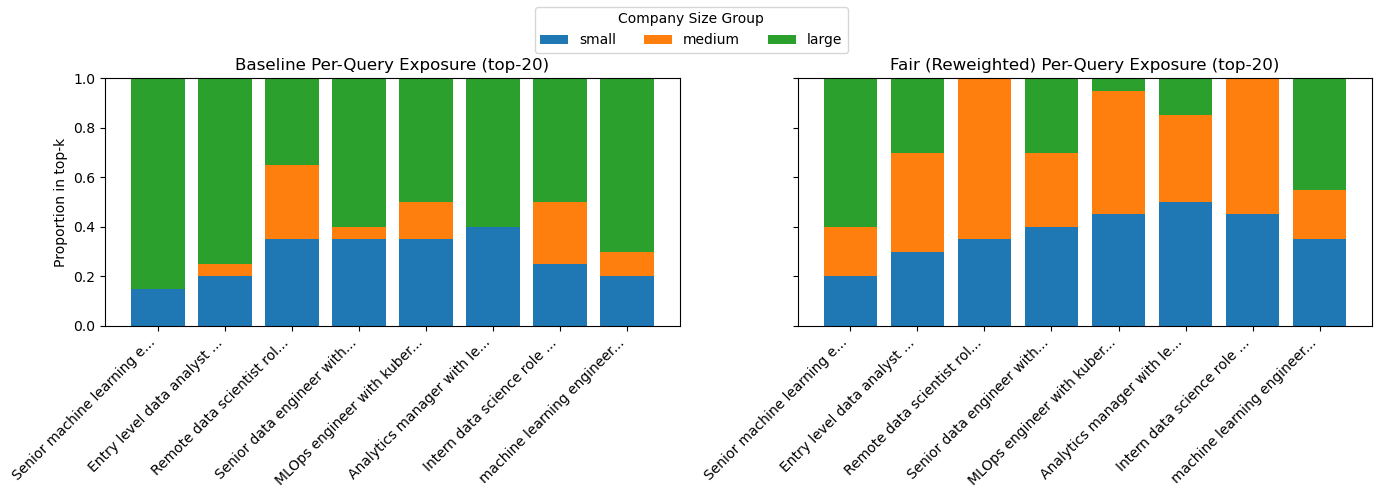

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
# Helper: compute per-query exposure for a given recommender
# ============================================================
def compute_per_query_exposure(recommender_fn, queries, top_k=20, name="model"):
    groups = ["small", "medium", "large"]
    rows = []

    for q in queries:
        recs = recommender_fn(q, top_k=top_k)

        # ensure unknowns are removed
        recs = recs[recs["company_size_group"] != "unknown"].copy()

        counts = recs["company_size_group"].value_counts()
        total = counts.sum()

        row = {"query": q, "total": int(total)}
        for g in groups:
            c = int(counts.get(g, 0))
            row[g] = c
            row[g + "_share"] = c / total if total > 0 else 0.0
        rows.append(row)

    per_query_df = pd.DataFrame(rows)

    # short labels for x-axis
    per_query_df["query_label"] = per_query_df["query"].str.slice(0, 25) + np.where(
        per_query_df["query"].str.len() > 25, "...", ""
    )

    return per_query_df


# ============================================================
# Compute per-query exposure for baseline and fair models
# ============================================================
top_k = 20

baseline_per_query = compute_per_query_exposure(
    recommender_fn=search_jobs,
    queries=text_queries,
    top_k=top_k,
    name="Baseline",
)

fair_per_query = compute_per_query_exposure(
    recommender_fn=search_jobs_fair,
    queries=text_queries,
    top_k=top_k,
    name="Fair (reweighted)",
)

# ============================================================
# Side-by-side stacked bar plots: BEFORE vs AFTER
# ============================================================
groups = ["small", "medium", "large"]
colors = {"small": "tab:blue", "medium": "tab:orange", "large": "tab:green"}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# ---------- Baseline ----------
ax = axes[0]
bottom = np.zeros(len(baseline_per_query))
for g in groups:
    ax.bar(
        baseline_per_query["query_label"],
        baseline_per_query[g + "_share"],
        bottom=bottom,
        label=g if g == "small" else None,  # legend only once
        color=colors[g],
    )
    bottom += baseline_per_query[g + "_share"].values

ax.set_title(f"Baseline Per-Query Exposure (top-{top_k})")
ax.set_ylabel("Proportion in top-k")
ax.set_xticklabels(baseline_per_query["query_label"], rotation=45, ha="right")

# ---------- Fair (reweighted) ----------
ax = axes[1]
bottom = np.zeros(len(fair_per_query))
for g in groups:
    ax.bar(
        fair_per_query["query_label"],
        fair_per_query[g + "_share"],
        bottom=bottom,
        label=g,
        color=colors[g],
    )
    bottom += fair_per_query[g + "_share"].values

ax.set_title(f"Fair (Reweighted) Per-Query Exposure (top-{top_k})")
ax.set_xticklabels(fair_per_query["query_label"], rotation=45, ha="right")

# Put legend once, outside
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Company Size Group", loc="upper center", ncol=3)

plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()


In [181]:
import pandas as pd

# ============================================================
# Diversity-aware FAIR recommender:
#   - Uses fair_score (reweighted similarity)
#   - Limits max jobs per company in top-k
#   - If not enough diverse companies, falls back to fill top_k
# ============================================================
def search_jobs_fair_diverse(
    query_text,
    top_k=20,
    max_per_company=2,
    candidate_k=500,   # larger pool to find more companies
):
    """
    Fairness + Diversity recommender:
      - embed query
      - compute similarity
      - apply group weights (fair_score)
      - take top `candidate_k` candidates
      - greedily select at most `max_per_company` per company
      - if still < top_k, fill remaining slots ignoring cap
      - drop unknown company_size_group
    """
    # --------------------------------------------------------
    # 1) Embed query and get baseline similarities
    # --------------------------------------------------------
    q_vec = embed_query_text(query_text)
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    ranked_idx = np.argsort(-sims)
    candidates = df.iloc[ranked_idx].copy()
    candidates["similarity"] = sims[ranked_idx]

    # Drop unknown size group
    candidates = candidates[candidates["company_size_group"] != "unknown"].copy()

    # --------------------------------------------------------
    # 2) Apply group weights (same as search_jobs_fair)
    # --------------------------------------------------------
    def get_weight(group):
        return GROUP_WEIGHTS.get(group, 1.0)

    candidates["fair_weight"] = candidates["company_size_group"].apply(get_weight)
    candidates["fair_score"] = candidates["similarity"] * candidates["fair_weight"]

    # Sort by fair_score and keep only top candidate_k
    candidate_k = min(candidate_k, len(candidates))
    candidates = candidates.sort_values("fair_score", ascending=False).head(candidate_k)

    # We'll track row indices so we don't add duplicates in fallback
    candidates = candidates.reset_index(drop=False)  # keep original index
    candidates.rename(columns={"index": "_orig_idx"}, inplace=True)

    # --------------------------------------------------------
    # 3) First pass: greedy selection with per-company cap
    # --------------------------------------------------------
    selected_rows = []
    selected_ids = set()
    company_counts = {}

    for _, row in candidates.iterrows():
        company = row.get("company", "_no_company_")
        if pd.isna(company):
            company = "_no_company_"

        current = company_counts.get(company, 0)
        if current >= max_per_company:
            continue

        selected_rows.append(row)
        selected_ids.add(row["_orig_idx"])
        company_counts[company] = current + 1

        if len(selected_rows) >= top_k:
            break

    # --------------------------------------------------------
    # 4) Fallback pass: if not enough selected, fill ignoring cap
    # --------------------------------------------------------
    if len(selected_rows) < top_k:
        for _, row in candidates.iterrows():
            if len(selected_rows) >= top_k:
                break
            if row["_orig_idx"] in selected_ids:
                continue  # skip already selected
            selected_rows.append(row)
            selected_ids.add(row["_orig_idx"])

    # --------------------------------------------------------
    # 5) Build final DataFrame
    # --------------------------------------------------------
    results = pd.DataFrame(selected_rows)

    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
        "fair_weight",
        "fair_score",
    ]
    cols = [c for c in cols if c in results.columns]
    return results[cols]



# Quick sanity check
q_test = "Senior machine learning engineer with python"
print("\n=== Fair (reweighted) top-10 ===")
print(search_jobs_fair(q_test, top_k=10).to_string(index=False))

print("\n=== Fair + Diverse (max 2 per company) top-10 ===")
print(search_jobs_fair_diverse(q_test, top_k=10, max_per_company=2).to_string(index=False))



=== Fair (reweighted) top-10 ===
                job_title company_size_group  salary_max seniority_level                                             skills_clean  similarity  fair_weight  fair_score
machine learning engineer              small     36342.0          senior                                                             0.727699          0.9    0.654929
machine learning engineer              small     36345.0          senior                                                             0.727695          0.9    0.654925
           data scientist             medium      9140.0          senior                     r|python|sql|hadoop|machine learning    0.653939          1.0    0.653939
machine learning engineer              small     44207.0          senior                                                             0.715761          0.9    0.644185
machine learning engineer              large     26186.0          senior                            azure|machine learning|python  

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [182]:
top_k = 20

baseline_summary, baseline_sim = measure_exposure_bias_text_queries(
    recommender_fn=search_jobs,
    queries=text_queries,
    top_k=top_k,
    name="Baseline",
)

fair_summary, fair_sim = measure_exposure_bias_text_queries(
    recommender_fn=search_jobs_fair,
    queries=text_queries,
    top_k=top_k,
    name="Fair (Reweighted)",
)

fair_div_summary, fair_div_sim = measure_exposure_bias_text_queries(
    recommender_fn=search_jobs_fair_diverse,
    queries=text_queries,
    top_k=top_k,
    name="Fair + Diverse",
)


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49


=== Baseline — Text-Query Exposure Bias Summary (top-20) ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.28125        1.269055
            medium       0.184865         0.11250        0.608553
             large       0.593514         0.60625        1.021459

Baseline — Average similarity across queries: 0.6393

=== Fair (Reweighted) — Text-Query Exposure Bias Summary (top-20) ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.37500        1.692073
            medium       0.184865         0.39375        2.129934
             large       0.593514         0.23125        0.389629

Fair (Reweighted) — Average similarity across queries: 0.6183

=== Fair + Diverse — Text-Query Exposure Bias Summary (top-20) ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622         0.37500        1.692073
            medium    

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

In [183]:
def measure_company_diversity(recommender_fn, queries, top_k, name):
    uniq_counts = []
    for q in queries:
        recs = recommender_fn(q, top_k=top_k)
        if "company" in recs.columns and len(recs) > 0:
            uniq_counts.append(recs["company"].nunique())
    avg_uniq = float(np.mean(uniq_counts)) if uniq_counts else float("nan")
    print(f"{name} — Avg unique companies per query (top-{top_k}): {avg_uniq:.2f}")
    return avg_uniq

baseline_div = measure_company_diversity(search_jobs, text_queries, top_k, "Baseline")
fair_div = measure_company_diversity(search_jobs_fair, text_queries, top_k, "Fair (Reweighted)")
fair_div2 = measure_company_diversity(search_jobs_fair_diverse, text_queries, top_k, "Fair + Diverse")


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

Baseline — Avg unique companies per query (top-20): nan
Fair (Reweighted) — Avg unique companies per query (top-20): nan
Fair + Diverse — Avg unique companies per query (top-20): nan


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49

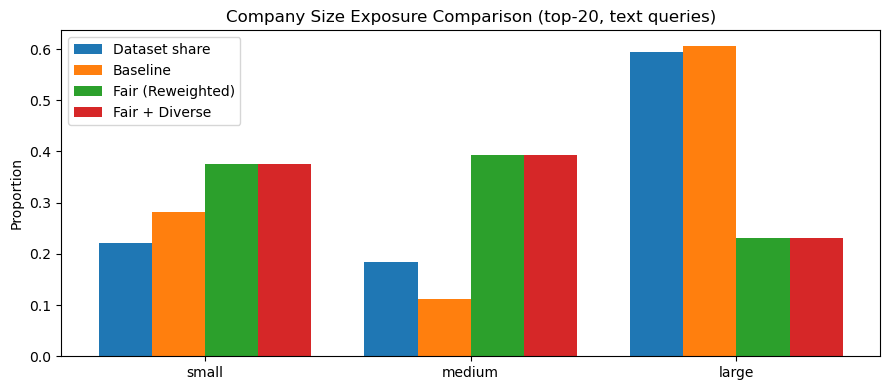


Baseline avg similarity:      0.6393
Fair (Reweighted) similarity: 0.6183
Fair + Diverse similarity:    0.6183


In [184]:
# ============================================================
# Exposure comparison: dataset vs 3 models
# ============================================================
groups = baseline_summary["company_size_group"]

dataset_share = baseline_summary["dataset_share"]
baseline_exposure = baseline_summary["exposure_share"]
fair_exposure = fair_summary["exposure_share"]
fair_div_exposure = fair_div_summary["exposure_share"]

x = np.arange(len(groups))
width = 0.2

plt.figure(figsize=(9, 4))

plt.bar(x - 1.5*width, dataset_share, width, label="Dataset share")
plt.bar(x - 0.5*width, baseline_exposure, width, label="Baseline")
plt.bar(x + 0.5*width, fair_exposure, width, label="Fair (Reweighted)")
plt.bar(x + 1.5*width, fair_div_exposure, width, label="Fair + Diverse")

plt.xticks(x, groups)
plt.ylabel("Proportion")
plt.title(f"Company Size Exposure Comparison (top-{top_k}, text queries)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBaseline avg similarity:      {baseline_sim:.4f}")
print(f"Fair (Reweighted) similarity: {fair_sim:.4f}")
print(f"Fair + Diverse similarity:    {fair_div_sim:.4f}")


In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Rank-aware evaluation for one recommender model
# ============================================================

def evaluate_model_rank_fairness(
    recommender_fn,
    name,
    queries,
    top_k=20,
    groups=("small", "medium", "large"),
):
    """
    For a given recommender_fn(query, top_k), compute:

      1. Selection Rate (SR) per group
      2. Rank-aware Exposure per group using DCG weights: 1/log2(rank+1)
      3. Exposure share per group
      4. Proportional Fairness Error (PFE)

    Returns:
      metrics_df (per-group) and scalar PFE.
    """

    # ---- Dataset-level group sizes & shares (exclude unknown) ----
    df_valid = df[df["company_size_group"] != "unknown"].copy()
    dataset_counts = df_valid["company_size_group"].value_counts()
    dataset_counts = dataset_counts.reindex(groups).fillna(0).astype(int)
    dataset_total = dataset_counts.sum()
    dataset_share = dataset_counts / dataset_total

    # ---- Aggregators ----
    selection_counts = {g: 0 for g in groups}   # how many times group appears in top-k
    exposure_scores   = {g: 0.0 for g in groups}  # sum of DCG exposure per group

    num_queries = len(queries)

    # ---- Process each query ----
    for q in queries:
        recs = recommender_fn(q, top_k=top_k)

        # drop unknown groups if any remain
        recs = recs[recs["company_size_group"] != "unknown"].copy()
        if recs.empty:
            continue

        # ensure we have positional ranks
        recs = recs.reset_index(drop=True)

        for i, (_, row) in enumerate(recs.iterrows()):
            g = row["company_size_group"]
            if g not in groups:
                continue

            # selection count (position-agnostic)
            selection_counts[g] += 1

            # DCG-style exposure: 1 / log2(rank+1)
            rank = i + 1  # 1-based
            exposure = 1.0 / np.log2(rank + 1)
            exposure_scores[g] += exposure

    # ---- 1. Selection Rate (SR) per group ----
    # SR_g = (# jobs selected for group) / (# jobs in group * #queries)
    selection_rate = {}
    for g in groups:
        denom = dataset_counts[g] * max(num_queries, 1)
        selection_rate[g] = selection_counts[g] / denom if denom > 0 else 0.0

    # ---- 2. Rank-aware exposure share per group ----
    total_exposure = sum(exposure_scores.values())
    exposure_share = {}
    for g in groups:
        exposure_share[g] = (
            exposure_scores[g] / total_exposure if total_exposure > 0 else 0.0
        )

    # ---- 3. Proportional Fairness Error (PFE) ----
    # PFE = sum_g | exposure_share_g - dataset_share_g |
    pfe = float(
        sum(abs(exposure_share[g] - dataset_share[g]) for g in groups)
    )

    # ---- Build metrics DataFrame ----
    rows = []
    for g in groups:
        rows.append({
            "model": name,
            "company_size_group": g,
            "dataset_share": dataset_share[g],
            "selection_rate": selection_rate[g],
            "exposure_share": exposure_share[g],
        })

    metrics_df = pd.DataFrame(rows)

    print(f"\n=== {name} — Rank-Fairness Metrics (top-{top_k}) ===")
    print(metrics_df.to_string(index=False))
    print(f"{name} — Proportional Fairness Error (PFE): {pfe:.4f}")

    return metrics_df, pfe


In [186]:
top_k = 20

metrics_baseline, pfe_baseline = evaluate_model_rank_fairness(
    recommender_fn=search_jobs,
    name="Baseline",
    queries=text_queries,
    top_k=top_k,
)

metrics_fair, pfe_fair = evaluate_model_rank_fairness(
    recommender_fn=search_jobs_fair,
    name="Fair (Reweighted)",
    queries=text_queries,
    top_k=top_k,
)

metrics_fair_div, pfe_fair_div = evaluate_model_rank_fairness(
    recommender_fn=search_jobs_fair_diverse,
    name="Fair + Diverse",
    queries=text_queries,
    top_k=top_k,
)


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49


=== Baseline — Rank-Fairness Metrics (top-20) ===
   model company_size_group  dataset_share  selection_rate  exposure_share
Baseline              small       0.221622        0.027439        0.290094
Baseline             medium       0.184865        0.013158        0.123041
Baseline              large       0.593514        0.022086        0.586865
Baseline — Proportional Fairness Error (PFE): 0.1369

=== Fair (Reweighted) — Rank-Fairness Metrics (top-20) ===
            model company_size_group  dataset_share  selection_rate  exposure_share
Fair (Reweighted)              small       0.221622        0.036585        0.393612
Fair (Reweighted)             medium       0.184865        0.046053        0.429559
Fair (Reweighted)              large       0.593514        0.008424        0.176828
Fair (Reweighted) — Proportional Fairness Error (PFE): 0.8334


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:49


=== Fair + Diverse — Rank-Fairness Metrics (top-20) ===
         model company_size_group  dataset_share  selection_rate  exposure_share
Fair + Diverse              small       0.221622        0.036585        0.393612
Fair + Diverse             medium       0.184865        0.046053        0.429559
Fair + Diverse              large       0.593514        0.008424        0.176828
Fair + Diverse — Proportional Fairness Error (PFE): 0.8334


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [187]:
# ============================================================
# Combine metrics for plotting
# ============================================================

all_metrics = pd.concat([metrics_baseline, metrics_fair, metrics_fair_div], ignore_index=True)

print("\n=== Combined Metrics ===")
print(all_metrics.to_string(index=False))

print("\nPFE values:")
print(f"Baseline        PFE = {pfe_baseline:.4f}")
print(f"Fair (Reweight) PFE = {pfe_fair:.4f}")
print(f"Fair + Diverse  PFE = {pfe_fair_div:.4f}")



=== Combined Metrics ===
            model company_size_group  dataset_share  selection_rate  exposure_share
         Baseline              small       0.221622        0.027439        0.290094
         Baseline             medium       0.184865        0.013158        0.123041
         Baseline              large       0.593514        0.022086        0.586865
Fair (Reweighted)              small       0.221622        0.036585        0.393612
Fair (Reweighted)             medium       0.184865        0.046053        0.429559
Fair (Reweighted)              large       0.593514        0.008424        0.176828
   Fair + Diverse              small       0.221622        0.036585        0.393612
   Fair + Diverse             medium       0.184865        0.046053        0.429559
   Fair + Diverse              large       0.593514        0.008424        0.176828

PFE values:
Baseline        PFE = 0.1369
Fair (Reweight) PFE = 0.8334
Fair + Diverse  PFE = 0.8334
